In [1]:
# -*- coding: utf-8 -*-
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"
from os import path, listdir
import numpy as np
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
import timeit
import cv2
from tqdm import tqdm

import sys
sys.setrecursionlimit(10000)
from multiprocessing import Pool

from shapely.geometry.linestring import LineString
from skimage.morphology import skeletonize_3d, square, erosion, dilation, medial_axis
from skimage.measure import label, regionprops, approximate_polygon
from math import hypot, sin, cos, asin, acos, radians
from sklearn.neighbors import KDTree
from shapely.wkt import dumps

# import matplotlib.pyplot as plt
# import seaborn as sns

pred_folders = ['./wdata/test_pred']




In [2]:
def get_ordered_coords(lbl, l, coords):
    res = []
    
    nxt = coords[0]
    for i in range(coords.shape[0]):
        y, x = coords[i]
        cnt = 0
        for y0 in range(max(0, y-1), min(1300, y+2)):
            for x0 in range(max(0, x-1), min(1300, x+2)):
                if lbl[y0, x0] == l:
                    cnt += 1
        if cnt == 2:
            nxt = coords[i]
            lbl[y, x] = 0
            res.append(nxt)
            break
    while nxt is not None:
        y, x = nxt
        fl = False
        for y0 in range(max(0, y-1), min(1300, y+2)):
            for x0 in range(max(0, x-1), min(1300, x+2)):
                if lbl[y0, x0] == l:
                    fl = True
                    nxt = np.asarray([y0, x0])
                    lbl[y0, x0] = 0
                    res.append(nxt)
                    break
            if fl:
                break
        if not fl:
            nxt = None
    return np.asarray(res)
    
    
def point_hash(x, y):
    x_int = int(x)
    y_int = int(y)
    h = x_int * 10000 + y_int
    return h


def pair_hash(p1, p2):
    h1 = point_hash(p1[0], p1[1])
    h2 = point_hash(p2[0], p2[1])
    return np.int64(h1 * 1e8 + h2)


def get_next_point(p1, p2, add_dist):
    l = hypot(p1[0] - p2[0], p1[1] - p2[1])
    dx = (p2[1] - p1[1]) / l
    dy = (p2[0] - p1[0]) / l
    x3 = int(round(p1[1] + (l + add_dist) * dx))
    y3 = int(round(p1[0] + (l + add_dist) * dy))
    if x3 < 0:
        x3 = 0
    if y3 < 0:
        y3 = 0
    if x3 > 1299:
        x3 = 1299
    if y3 > 1299:
        y3 = 1299
    return np.asarray([y3, x3])


def try_connect(p1, p2, a, max_dist, road_msk, min_prob, msk, roads, r=3):
    prob = []
    r_id = road_msk[p2[0], p2[1]]
    hashes = set([point_hash(p2[1], p2[0])])
    l = hypot(p1[0] - p2[0], p1[1] - p2[1])
    dx = (p2[1] - p1[1]) / l
    dy = (p2[0] - p1[0]) / l
    if a != 0:
        l = 0
        p1 = p2
        _a = asin(dy) + a
        dy = sin(_a)
        _a = acos(dx) + a
        dx = cos(_a)
    step = 0.5
    d = step
    while d < max_dist:
        x3 = int(round(p1[1] + (l + d) * dx))
        y3 = int(round(p1[0] + (l + d) * dy))
        if x3 < 0 or y3 < 0 or x3 > 1299 or y3 > 1299:
            return None
        h = point_hash(x3, y3)
        if h not in hashes:
            prob.append(msk[y3, x3])
            hashes.add(h)
            for x0 in range(max(0, x3 - r), min(1299, x3 + r + 1)):
                for y0 in range(max(0, y3 - r), min(1299, y3 + r + 1)):
                    if road_msk[y0, x0] > 0 and road_msk[y0, x0] != r_id:
                        p3 = np.asarray([y0, x0])
                        r2_id = road_msk[y0, x0] - 1
                        t = KDTree(roads[r2_id])
                        clst = t.query(p3[np.newaxis, :])
                        if clst[0][0][0] < 10:
                            p3 = roads[r2_id][clst[1][0][0]]
                        if np.asarray(prob).mean() > min_prob:
                            return p3
                        else:
                            return None
        d += step
    return None


def inject_point(road, p):
    for i in range(road.shape[0]):
        if road[i, 0] == p[0] and road[i, 1] == p[1]:
            return road, []
    new_road = []
    to_add = True
    new_hashes = []
    for i in range(road.shape[0] - 1):
        new_road.append(road[i])
        if (to_add and min(road[i, 0], road[i+1, 0]) <= p[0] 
            and max(road[i, 0], road[i+1, 0]) >= p[0]
            and min(road[i, 1], road[i+1, 1]) <= p[1]
            and max(road[i, 1], road[i+1, 1]) >= p[1]):
            to_add = False
            new_road.append(p)
            new_hashes.append(pair_hash(p, road[i]))
            new_hashes.append(pair_hash(road[i], p))
            new_hashes.append(pair_hash(p, road[i+1]))
            new_hashes.append(pair_hash(road[i+1], p))
    new_road.append(road[-1])
    return np.asarray(new_road), new_hashes



In [19]:
res_rows = []

msks = []
img = './wdata/test_pred/SN5_roads_test_public_AOI_7_Moscow_chip100.png'
msk = cv2.imread(img, cv2.IMREAD_UNCHANGED)


In [20]:
msk = msk.max(axis=2)

msk.shape

(1312, 1312)

In [21]:
if msk.shape[0] < 1306:
    msk = cv2.resize(msk, (1300, 1300))
    msk = np.pad(msk, ((6, 6), (6, 6)), mode='reflect')
else:
    msk = msk[6:1306, 6:1306]
    msk = np.pad(msk, ((6, 6), (6, 6)), mode='reflect')
msks.append(msk)

In [25]:
msks = np.asarray(msks)
msk = msks.mean(axis=0)

thr = 120

msk2 = 1 * (msk > thr)
msk2 = msk2.astype(np.uint8)


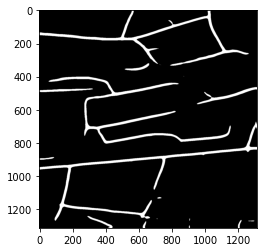

In [26]:
from matplotlib import pyplot as plt
plt.imshow(msk2, cmap='gray')

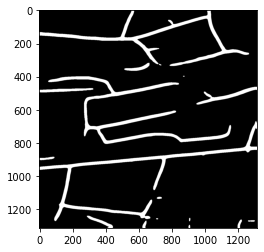

In [27]:
msk2 = dilation(msk2, square(5))
plt.imshow(msk2, cmap='gray')

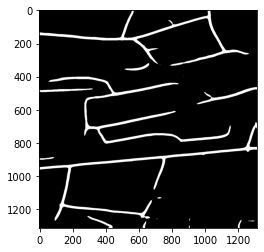

In [28]:
msk2 = erosion(msk2, square(5))
plt.imshow(msk2, cmap='gray')

In [45]:
skeleton = skeletonize_3d(msk2)
skeleton = skeleton[6:1306, 6:1306]

lbl0 = label(skeleton)
props0 = regionprops(lbl0)

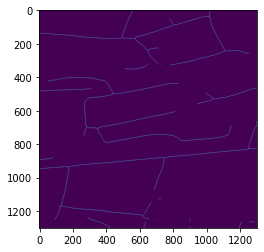

In [37]:
plt.imshow(skeleton)

In [46]:
cnt = 0
crosses = []
for x in range(1300):
    for y in range(1300):
        if skeleton[y, x] == 1:
            if skeleton[max(0, y-1):min(1300, y+2), max(0, x-1):min(1300, x+2)].sum() > 3:
                cnt += 1
                crss = []
                crss.append((x, y))
                for y0 in range(max(0, y-1), min(1300, y+2)):
                    for x0 in range(max(0, x-1), min(1300, x+2)):
                        if x == x0 and y == y0:
                            continue
                        if skeleton[max(0, y0-1):min(1300, y0+2), max(0, x0-1):min(1300, x0+2)].sum() > 3:
                            crss.append((x0, y0))
                crosses.append(crss)
cross_hashes = []
for crss in crosses:
    crss_hash = set([])
    for x0, y0 in crss:
        crss_hash.add(point_hash(x0, y0))
        skeleton[y0, x0] = 0
    cross_hashes.append(crss_hash)
    

In [50]:
new_crosses = []
i = 0
while i < len(crosses):
    new_hashes = set([])
    new_hashes.update(cross_hashes[i])
    new_crss = crosses[i][:]
    fl = True
    while fl:
        fl = False
        j = i + 1
        while j < len(crosses):
            if len(new_hashes.intersection(cross_hashes[j])) > 0:
                new_hashes.update(cross_hashes[j])
                new_crss.extend(crosses[j])
                cross_hashes.pop(j)
                crosses.pop(j)
                fl = True
                break
            j += 1
    mean_p = np.asarray(new_crss).mean(axis=0).astype('int')
    if len(new_crss) > 1:
        t = KDTree(np.asarray(new_crss))
        mean_p = new_crss[t.query(mean_p[np.newaxis, :])[1][0][0]]
    new_crosses.append([(mean_p[0], mean_p[1])] + new_crss)
    i += 1
crosses = new_crosses

lbl = label(skeleton)
props = regionprops(lbl)

connected_roads = []
connected_crosses = [set([]) for p in props]
for i in range(len(crosses)):
    rds = set([])
    for j in range(len(crosses[i])):
        x, y = crosses[i][j]
        for y0 in range(max(0, y-1), min(1300, y+2)):
            for x0 in range(max(0, x-1), min(1300, x+2)):
                if lbl[y0, x0] > 0:
                    rds.add(lbl[y0, x0])
                    connected_crosses[lbl[y0, x0]-1].add(i)
    connected_roads.append(rds)

res_roads = []

tot_dist_min = 20
coords_min = 10


In [51]:
connected_roads

[{44, 45, 47},
 {41, 45, 46},
 {37, 40, 41},
 {24, 32, 33},
 {26, 29, 32},
 {19, 20, 24},
 {1, 7, 8},
 {6, 8, 9},
 {43, 46, 48},
 {9, 10, 11},
 {35, 37, 39},
 {3, 5, 6},
 {2, 3, 4},
 {21, 23, 25},
 {4, 12, 13},
 {30, 34, 35, 36},
 {28, 30, 31}]

In [52]:
for i in range(len(props)):
    coords = props[i].coords
    crss = list(connected_crosses[i])
    tot_dist = props0[lbl0[coords[0][0], coords[0][1]]-1].area

    if (tot_dist < tot_dist_min) or (coords.shape[0] < coords_min and len(crss) < 2):
        continue
    if coords.shape[0] == 1:
        coords = np.asarray([coords[0], coords[0]])
    else:
        coords = get_ordered_coords(lbl, i+1, coords)
    for j in range(len(crss)):
        x, y = crosses[crss[j]][0]
        d1 = abs(coords[0][0] - y) + abs(coords[0][1] - x)
        d2 = abs(coords[-1][0] - y) + abs(coords[-1][1] - x)
        if d1 < d2:
            coords[0][0] = y
            coords[0][1] = x
        else:
            coords[-1][0] = y
            coords[-1][1] = x
    coords_approx = approximate_polygon(coords, 1.5)
    res_roads.append(coords_approx)


In [55]:
hashes = set([])
final_res_roads = []
for r in res_roads:
    if r.shape[0] > 2:
        final_res_roads.append(r)
        for i in range(1, r.shape[0]):
            p1 = r[i-1]
            p2 = r[i]
            h1 = pair_hash(p1, p2)
            h2 = pair_hash(p2, p1)
            hashes.add(h1)
            hashes.add(h2)

for r in res_roads:
    if r.shape[0] == 2:
        p1 = r[0]
        p2 = r[1]
        h1 = pair_hash(p1, p2)
        h2 = pair_hash(p2, p1)
        if not (h1 in hashes or h2 in hashes):
            final_res_roads.append(r)
            hashes.add(h1)
            hashes.add(h2)

end_points = {}
for r in res_roads:
    h = point_hash(r[0, 0], r[0, 1])
    if not (h in end_points.keys()):
        end_points[h] = 0
    end_points[h] = end_points[h] + 1
    h = point_hash(r[-1, 0], r[-1, 1])
    if not (h in end_points.keys()):
        end_points[h] = 0
    end_points[h] = end_points[h] + 1


In [60]:
road_msk = np.zeros((1300, 1300), dtype=np.int32)
road_msk = road_msk.copy()
thickness = 1
for j in range(len(final_res_roads)):
    l = final_res_roads[j]
    for i in range(len(l) - 1):
        cv2.line(road_msk, (int(l[i, 1]), int(l[i, 0])), (int(l[i+1, 1]), int(l[i+1, 0])), j+1, thickness)

connect_dist = 110
min_prob = 30

angles_to_check = [0, radians(5), radians(-5), radians(10), radians(-10), radians(15), radians(-15)]

angles_to_check += [radians(20), radians(-20), radians(25), radians(-25)]

add_dist = 30
add_dist2 = 6

con_r = 8

for i in range(len(final_res_roads)):
    h = point_hash(final_res_roads[i][0, 0], final_res_roads[i][0, 1])
    if end_points[h] == 1:
        p1 = final_res_roads[i][1]
        p2 = final_res_roads[i][0]            
        p3 = try_connect(p1, p2, 0, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
        if p3 is not None:
            h1 = pair_hash(p2, p3)
            h2 = pair_hash(p3, p2)
            if not (h1 in hashes or h2 in hashes):
                r_id = road_msk[p3[0], p3[1]] - 1
                final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                hashes.update(new_hashes)          
                tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                tmp_road_msk = tmp_road_msk.copy()
                cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                road_msk = road_msk.copy()
                final_res_roads[i] = np.vstack((p3, final_res_roads[i]))
                hashes.add(h1)
                hashes.add(h2)
                end_points[point_hash(p3[0], p3[1])] = 2
    h = point_hash(final_res_roads[i][-1, 0], final_res_roads[i][-1, 1])
    if end_points[h] == 1:
        p1 = final_res_roads[i][-2]
        p2 = final_res_roads[i][-1]
        p3 = try_connect(p1, p2, 0, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
        if p3 is not None:
            h1 = pair_hash(p2, p3)
            h2 = pair_hash(p3, p2)
            if not (h1 in hashes or h2 in hashes):
                r_id = road_msk[p3[0], p3[1]] - 1
                final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                hashes.update(new_hashes)
                tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                tmp_road_msk = tmp_road_msk.copy()
                cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                road_msk = road_msk.copy()
                final_res_roads[i] = np.vstack((final_res_roads[i], p3))
                hashes.add(h1)
                hashes.add(h2)
                end_points[point_hash(p3[0], p3[1])] = 2

for i in range(len(final_res_roads)):
    h = point_hash(final_res_roads[i][0, 0], final_res_roads[i][0, 1])
    if end_points[h] == 1:
        p1 = final_res_roads[i][1]
        p2 = final_res_roads[i][0]
        p3 = None
        for a in angles_to_check:
            p3 = try_connect(p1, p2, a, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
            if p3 is not None:
                break
        if p3 is not None:
            h1 = pair_hash(p2, p3)
            h2 = pair_hash(p3, p2)
            if not (h1 in hashes or h2 in hashes):
                r_id = road_msk[p3[0], p3[1]] - 1
                final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                hashes.update(new_hashes)          
                tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                tmp_road_msk = tmp_road_msk.copy()
                cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                road_msk = road_msk.copy()
                final_res_roads[i] = np.vstack((p3, final_res_roads[i]))
                hashes.add(h1)
                hashes.add(h2)
                end_points[point_hash(p3[0], p3[1])] = 2
        else:
            p3 = get_next_point(p1, p2, add_dist)
            if not (p3[0] < 2 or p3[1] < 2 or p3[0] > 1297 or p3[1] > 1297):
                p3 = get_next_point(p1, p2, add_dist2)
            if (p3[0] != p2[0] or p3[1] != p2[1]) and (road_msk[p3[0], p3[1]] == 0):
                h1 = pair_hash(p2, p3)
                h2 = pair_hash(p3, p2)
                if not (h1 in hashes or h2 in hashes):
                    final_res_roads[i] = np.vstack((p3, final_res_roads[i]))
                    hashes.add(h1)
                    hashes.add(h2)
                    tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                    tmp_road_msk = tmp_road_msk.copy()
                    cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                    road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                    road_msk = road_msk.copy()
                    end_points[point_hash(p3[0], p3[1])] = 2

    h = point_hash(final_res_roads[i][-1, 0], final_res_roads[i][-1, 1])
    if end_points[h] == 1:
        p1 = final_res_roads[i][-2]
        p2 = final_res_roads[i][-1]
        p3 = None
        for a in angles_to_check:
            p3 = try_connect(p1, p2, a, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
            if p3 is not None:
                break
        if p3 is not None:
            h1 = pair_hash(p2, p3)
            h2 = pair_hash(p3, p2)
            if not (h1 in hashes or h2 in hashes):
                r_id = road_msk[p3[0], p3[1]] - 1
                final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                hashes.update(new_hashes)
                tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                tmp_road_msk = tmp_road_msk.copy()
                cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                road_msk = road_msk.copy()
                final_res_roads[i] = np.vstack((final_res_roads[i], p3))
                hashes.add(h1)
                hashes.add(h2)
                end_points[point_hash(p3[0], p3[1])] = 2
        else:
            p3 = get_next_point(p1, p2, add_dist)
            if not (p3[0] < 2 or p3[1] < 2 or p3[0] > 1297 or p3[1] > 1297):
                p3 = get_next_point(p1, p2, add_dist2)
            if (p3[0] != p2[0] or p3[1] != p2[1]) and (road_msk[p3[0], p3[1]] == 0):
                h1 = pair_hash(p2, p3)
                h2 = pair_hash(p3, p2)
                if not (h1 in hashes or h2 in hashes):
                    final_res_roads[i] = np.vstack((final_res_roads[i], p3))
                    hashes.add(h1)
                    hashes.add(h2)
                    tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                    tmp_road_msk = tmp_road_msk.copy()
                    cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                    road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                    road_msk = road_msk.copy()
                    end_points[point_hash(p3[0], p3[1])] = 2

lines = [LineString(r[:, ::-1]) for r in final_res_roads]

res_rows = []
if len(lines) == 0:
    res_rows.append({'ImageId': img_id, 'WKT_Pix': 'LINESTRING EMPTY'})
else:
    for l in lines:
        res_rows.append({'ImageId': img_id, 'WKT_Pix': dumps(l, rounding_precision=0)})   


In [61]:
res_rows

[{'ImageId': 100,
  'WKT_Pix': 'LINESTRING (562 0, 557 0, 555 11, 539 40, 517 91, 500 141, 496 165)'},
 {'ImageId': 100, 'WKT_Pix': 'LINESTRING (1015 0, 1017 2, 1019 26, 1017 36)'},
 {'ImageId': 100,
  'WKT_Pix': 'LINESTRING (1017 36, 979 40, 831 84, 808 88, 803 87)'},
 {'ImageId': 100,
  'WKT_Pix': 'LINESTRING (1017 36, 1025 77, 1038 114, 1079 185, 1091 210, 1103 228, 1107 242)'},
 {'ImageId': 100,
  'WKT_Pix': 'LINESTRING (771 53, 776 57, 791 68, 798 82, 803 87)'},
 {'ImageId': 100,
  'WKT_Pix': 'LINESTRING (803 87, 799 92, 790 96, 678 133, 609 154, 584 159, 577 162, 572 168)'},
 {'ImageId': 100,
  'WKT_Pix': 'LINESTRING (0 135, 1 137, 66 141, 107 146, 144 147, 223 155, 251 160, 336 164, 379 169, 463 169, 496 165)'},
 {'ImageId': 100, 'WKT_Pix': 'LINESTRING (496 165, 504 168, 572 168)'},
 {'ImageId': 100,
  'WKT_Pix': 'LINESTRING (572 168, 578 181, 601 196, 621 213, 638 233, 647 238)'},
 {'ImageId': 100,
  'WKT_Pix': 'LINESTRING (720 226, 714 226, 676 229, 657 233, 647 238)'},
 {'Ima

In [ ]:
    new_crosses = []
    i = 0
    while i < len(crosses):
        new_hashes = set([])
        new_hashes.update(cross_hashes[i])
        new_crss = crosses[i][:]
        fl = True
        while fl:
            fl = False
            j = i + 1
            while j < len(crosses):
                if len(new_hashes.intersection(cross_hashes[j])) > 0:
                    new_hashes.update(cross_hashes[j])
                    new_crss.extend(crosses[j])
                    cross_hashes.pop(j)
                    crosses.pop(j)
                    fl = True
                    break
                j += 1
        mean_p = np.asarray(new_crss).mean(axis=0).astype('int')
        if len(new_crss) > 1:
            t = KDTree(np.asarray(new_crss))
            mean_p = new_crss[t.query(mean_p[np.newaxis, :])[1][0][0]]
        new_crosses.append([(mean_p[0], mean_p[1])] + new_crss)
        i += 1
    crosses = new_crosses
    
    lbl = label(skeleton)
    props = regionprops(lbl)
    
    connected_roads = []
    connected_crosses = [set([]) for p in props]
    for i in range(len(crosses)):
        rds = set([])
        for j in range(len(crosses[i])):
            x, y = crosses[i][j]
            for y0 in range(max(0, y-1), min(1300, y+2)):
                for x0 in range(max(0, x-1), min(1300, x+2)):
                    if lbl[y0, x0] > 0:
                        rds.add(lbl[y0, x0])
                        connected_crosses[lbl[y0, x0]-1].add(i)
        connected_roads.append(rds)


AttributeError: 'RegionProperties' object has no attribute 'axis_minor_length'

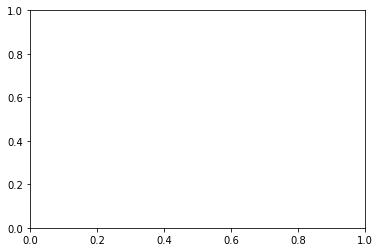

In [35]:
fig, ax = plt.subplots()
import math
# ax.imshow(image, cmap=plt.cm.gray)

for props in props0:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()

In [3]:
def get_ordered_coords(lbl, l, coords):
    res = []
    
    nxt = coords[0]
    for i in range(coords.shape[0]):
        y, x = coords[i]
        cnt = 0
        for y0 in range(max(0, y-1), min(1300, y+2)):
            for x0 in range(max(0, x-1), min(1300, x+2)):
                if lbl[y0, x0] == l:
                    cnt += 1
        if cnt == 2:
            nxt = coords[i]
            lbl[y, x] = 0
            res.append(nxt)
            break
    while nxt is not None:
        y, x = nxt
        fl = False
        for y0 in range(max(0, y-1), min(1300, y+2)):
            for x0 in range(max(0, x-1), min(1300, x+2)):
                if lbl[y0, x0] == l:
                    fl = True
                    nxt = np.asarray([y0, x0])
                    lbl[y0, x0] = 0
                    res.append(nxt)
                    break
            if fl:
                break
        if not fl:
            nxt = None
    return np.asarray(res)
    
    
def point_hash(x, y):
    x_int = int(x)
    y_int = int(y)
    h = x_int * 10000 + y_int
    return h


def pair_hash(p1, p2):
    h1 = point_hash(p1[0], p1[1])
    h2 = point_hash(p2[0], p2[1])
    return np.int64(h1 * 1e8 + h2)


def get_next_point(p1, p2, add_dist):
    l = hypot(p1[0] - p2[0], p1[1] - p2[1])
    dx = (p2[1] - p1[1]) / l
    dy = (p2[0] - p1[0]) / l
    x3 = int(round(p1[1] + (l + add_dist) * dx))
    y3 = int(round(p1[0] + (l + add_dist) * dy))
    if x3 < 0:
        x3 = 0
    if y3 < 0:
        y3 = 0
    if x3 > 1299:
        x3 = 1299
    if y3 > 1299:
        y3 = 1299
    return np.asarray([y3, x3])


def try_connect(p1, p2, a, max_dist, road_msk, min_prob, msk, roads, r=3):
    prob = []
    r_id = road_msk[p2[0], p2[1]]
    hashes = set([point_hash(p2[1], p2[0])])
    l = hypot(p1[0] - p2[0], p1[1] - p2[1])
    dx = (p2[1] - p1[1]) / l
    dy = (p2[0] - p1[0]) / l
    if a != 0:
        l = 0
        p1 = p2
        _a = asin(dy) + a
        dy = sin(_a)
        _a = acos(dx) + a
        dx = cos(_a)
    step = 0.5
    d = step
    while d < max_dist:
        x3 = int(round(p1[1] + (l + d) * dx))
        y3 = int(round(p1[0] + (l + d) * dy))
        if x3 < 0 or y3 < 0 or x3 > 1299 or y3 > 1299:
            return None
        h = point_hash(x3, y3)
        if h not in hashes:
            prob.append(msk[y3, x3])
            hashes.add(h)
            for x0 in range(max(0, x3 - r), min(1299, x3 + r + 1)):
                for y0 in range(max(0, y3 - r), min(1299, y3 + r + 1)):
                    if road_msk[y0, x0] > 0 and road_msk[y0, x0] != r_id:
                        p3 = np.asarray([y0, x0])
                        r2_id = road_msk[y0, x0] - 1
                        t = KDTree(roads[r2_id])
                        clst = t.query(p3[np.newaxis, :])
                        if clst[0][0][0] < 10:
                            p3 = roads[r2_id][clst[1][0][0]]
                        if np.asarray(prob).mean() > min_prob:
                            return p3
                        else:
                            return None
        d += step
    return None


def inject_point(road, p):
    for i in range(road.shape[0]):
        if road[i, 0] == p[0] and road[i, 1] == p[1]:
            return road, []
    new_road = []
    to_add = True
    new_hashes = []
    for i in range(road.shape[0] - 1):
        new_road.append(road[i])
        if (to_add and min(road[i, 0], road[i+1, 0]) <= p[0] 
            and max(road[i, 0], road[i+1, 0]) >= p[0]
            and min(road[i, 1], road[i+1, 1]) <= p[1]
            and max(road[i, 1], road[i+1, 1]) >= p[1]):
            to_add = False
            new_road.append(p)
            new_hashes.append(pair_hash(p, road[i]))
            new_hashes.append(pair_hash(road[i], p))
            new_hashes.append(pair_hash(p, road[i+1]))
            new_hashes.append(pair_hash(road[i+1], p))
    new_road.append(road[-1])
    return np.asarray(new_road), new_hashes

    
def process_file(img_id):
    res_rows = []
    
    msks = []
    for pred_folder in pred_folders:
        msk = cv2.imread(path.join(pred_folder, img_id + '.png'), cv2.IMREAD_UNCHANGED)
        msk = msk.max(axis=2)
        if msk.shape[0] < 1306:
            msk = cv2.resize(msk, (1300, 1300))
            msk = np.pad(msk, ((6, 6), (6, 6)), mode='reflect')
        else:
            msk = msk[6:1306, 6:1306]
            msk = np.pad(msk, ((6, 6), (6, 6)), mode='reflect')
        msks.append(msk)

    msks = np.asarray(msks)
    msk = msks.mean(axis=0)

    thr = 120
        
    msk2 = 1 * (msk > thr)
    msk2 = msk2.astype(np.uint8)
    
    msk2 = dilation(msk2, square(5))
    msk2 = erosion(msk2, square(5))
        
    skeleton = skeletonize_3d(msk2)
    skeleton = skeleton[6:1306, 6:1306]
    
    lbl0 = label(skeleton)
    props0 = regionprops(lbl0)
    
    cnt = 0
    crosses = []
    for x in range(1300):
        for y in range(1300):
            if skeleton[y, x] == 1:
                if skeleton[max(0, y-1):min(1300, y+2), max(0, x-1):min(1300, x+2)].sum() > 3:
                    cnt += 1
                    crss = []
                    crss.append((x, y))
                    for y0 in range(max(0, y-1), min(1300, y+2)):
                        for x0 in range(max(0, x-1), min(1300, x+2)):
                            if x == x0 and y == y0:
                                continue
                            if skeleton[max(0, y0-1):min(1300, y0+2), max(0, x0-1):min(1300, x0+2)].sum() > 3:
                                crss.append((x0, y0))
                    crosses.append(crss)
    cross_hashes = []
    for crss in crosses:
        crss_hash = set([])
        for x0, y0 in crss:
            crss_hash.add(point_hash(x0, y0))
            skeleton[y0, x0] = 0
        cross_hashes.append(crss_hash)
 
    new_crosses = []
    i = 0
    while i < len(crosses):
        new_hashes = set([])
        new_hashes.update(cross_hashes[i])
        new_crss = crosses[i][:]
        fl = True
        while fl:
            fl = False
            j = i + 1
            while j < len(crosses):
                if len(new_hashes.intersection(cross_hashes[j])) > 0:
                    new_hashes.update(cross_hashes[j])
                    new_crss.extend(crosses[j])
                    cross_hashes.pop(j)
                    crosses.pop(j)
                    fl = True
                    break
                j += 1
        mean_p = np.asarray(new_crss).mean(axis=0).astype('int')
        if len(new_crss) > 1:
            t = KDTree(np.asarray(new_crss))
            mean_p = new_crss[t.query(mean_p[np.newaxis, :])[1][0][0]]
        new_crosses.append([(mean_p[0], mean_p[1])] + new_crss)
        i += 1
    crosses = new_crosses
    
    lbl = label(skeleton)
    props = regionprops(lbl)
    
    connected_roads = []
    connected_crosses = [set([]) for p in props]
    for i in range(len(crosses)):
        rds = set([])
        for j in range(len(crosses[i])):
            x, y = crosses[i][j]
            for y0 in range(max(0, y-1), min(1300, y+2)):
                for x0 in range(max(0, x-1), min(1300, x+2)):
                    if lbl[y0, x0] > 0:
                        rds.add(lbl[y0, x0])
                        connected_crosses[lbl[y0, x0]-1].add(i)
        connected_roads.append(rds)
    
    res_roads = []
    
    tot_dist_min = 20
    coords_min = 10
        
    for i in range(len(props)):
        coords = props[i].coords
        crss = list(connected_crosses[i])
        tot_dist = props0[lbl0[coords[0][0], coords[0][1]]-1].area

        if (tot_dist < tot_dist_min) or (coords.shape[0] < coords_min and len(crss) < 2):
            continue
        if coords.shape[0] == 1:
            coords = np.asarray([coords[0], coords[0]])
        else:
            coords = get_ordered_coords(lbl, i+1, coords)
        for j in range(len(crss)):
            x, y = crosses[crss[j]][0]
            d1 = abs(coords[0][0] - y) + abs(coords[0][1] - x)
            d2 = abs(coords[-1][0] - y) + abs(coords[-1][1] - x)
            if d1 < d2:
                coords[0][0] = y
                coords[0][1] = x
            else:
                coords[-1][0] = y
                coords[-1][1] = x
        coords_approx = approximate_polygon(coords, 1.5)
        res_roads.append(coords_approx)
        
    hashes = set([])
    final_res_roads = []
    for r in res_roads:
        if r.shape[0] > 2:
            final_res_roads.append(r)
            for i in range(1, r.shape[0]):
                p1 = r[i-1]
                p2 = r[i]
                h1 = pair_hash(p1, p2)
                h2 = pair_hash(p2, p1)
                hashes.add(h1)
                hashes.add(h2)
                            
    for r in res_roads:
        if r.shape[0] == 2:
            p1 = r[0]
            p2 = r[1]
            h1 = pair_hash(p1, p2)
            h2 = pair_hash(p2, p1)
            if not (h1 in hashes or h2 in hashes):
                final_res_roads.append(r)
                hashes.add(h1)
                hashes.add(h2)
        
    end_points = {}
    for r in res_roads:
        h = point_hash(r[0, 0], r[0, 1])
        if not (h in end_points.keys()):
            end_points[h] = 0
        end_points[h] = end_points[h] + 1
        h = point_hash(r[-1, 0], r[-1, 1])
        if not (h in end_points.keys()):
            end_points[h] = 0
        end_points[h] = end_points[h] + 1
    
    road_msk = np.zeros((1300, 1300), dtype=np.int32)
    road_msk = road_msk.copy()
    thickness = 1
    for j in range(len(final_res_roads)):
        l = final_res_roads[j]
        for i in range(len(l) - 1):
            cv2.line(road_msk, (int(l[i, 1]), int(l[i, 0])), (int(l[i+1, 1]), int(l[i+1, 0])), j+1, thickness)
            
    connect_dist = 110
    min_prob = 30
    
    angles_to_check = [0, radians(5), radians(-5), radians(10), radians(-10), radians(15), radians(-15)]
    
    angles_to_check += [radians(20), radians(-20), radians(25), radians(-25)]
    
    add_dist = 30
    add_dist2 = 6
    
    con_r = 8

    for i in range(len(final_res_roads)):
        h = point_hash(final_res_roads[i][0, 0], final_res_roads[i][0, 1])
        if end_points[h] == 1:
            p1 = final_res_roads[i][1]
            p2 = final_res_roads[i][0]            
            p3 = try_connect(p1, p2, 0, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
            if p3 is not None:
                h1 = pair_hash(p2, p3)
                h2 = pair_hash(p3, p2)
                if not (h1 in hashes or h2 in hashes):
                    r_id = road_msk[p3[0], p3[1]] - 1
                    final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                    hashes.update(new_hashes)          
                    tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                    tmp_road_msk = tmp_road_msk.copy()
                    cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                    road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                    road_msk = road_msk.copy()
                    final_res_roads[i] = np.vstack((p3, final_res_roads[i]))
                    hashes.add(h1)
                    hashes.add(h2)
                    end_points[point_hash(p3[0], p3[1])] = 2
        h = point_hash(final_res_roads[i][-1, 0], final_res_roads[i][-1, 1])
        if end_points[h] == 1:
            p1 = final_res_roads[i][-2]
            p2 = final_res_roads[i][-1]
            p3 = try_connect(p1, p2, 0, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
            if p3 is not None:
                h1 = pair_hash(p2, p3)
                h2 = pair_hash(p3, p2)
                if not (h1 in hashes or h2 in hashes):
                    r_id = road_msk[p3[0], p3[1]] - 1
                    final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                    hashes.update(new_hashes)
                    tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                    tmp_road_msk = tmp_road_msk.copy()
                    cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                    road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                    road_msk = road_msk.copy()
                    final_res_roads[i] = np.vstack((final_res_roads[i], p3))
                    hashes.add(h1)
                    hashes.add(h2)
                    end_points[point_hash(p3[0], p3[1])] = 2
                        
    for i in range(len(final_res_roads)):
        h = point_hash(final_res_roads[i][0, 0], final_res_roads[i][0, 1])
        if end_points[h] == 1:
            p1 = final_res_roads[i][1]
            p2 = final_res_roads[i][0]
            p3 = None
            for a in angles_to_check:
                p3 = try_connect(p1, p2, a, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
                if p3 is not None:
                    break
            if p3 is not None:
                h1 = pair_hash(p2, p3)
                h2 = pair_hash(p3, p2)
                if not (h1 in hashes or h2 in hashes):
                    r_id = road_msk[p3[0], p3[1]] - 1
                    final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                    hashes.update(new_hashes)          
                    tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                    tmp_road_msk = tmp_road_msk.copy()
                    cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                    road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                    road_msk = road_msk.copy()
                    final_res_roads[i] = np.vstack((p3, final_res_roads[i]))
                    hashes.add(h1)
                    hashes.add(h2)
                    end_points[point_hash(p3[0], p3[1])] = 2
            else:
                p3 = get_next_point(p1, p2, add_dist)
                if not (p3[0] < 2 or p3[1] < 2 or p3[0] > 1297 or p3[1] > 1297):
                    p3 = get_next_point(p1, p2, add_dist2)
                if (p3[0] != p2[0] or p3[1] != p2[1]) and (road_msk[p3[0], p3[1]] == 0):
                    h1 = pair_hash(p2, p3)
                    h2 = pair_hash(p3, p2)
                    if not (h1 in hashes or h2 in hashes):
                        final_res_roads[i] = np.vstack((p3, final_res_roads[i]))
                        hashes.add(h1)
                        hashes.add(h2)
                        tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                        tmp_road_msk = tmp_road_msk.copy()
                        cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                        road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                        road_msk = road_msk.copy()
                        end_points[point_hash(p3[0], p3[1])] = 2
                        
        h = point_hash(final_res_roads[i][-1, 0], final_res_roads[i][-1, 1])
        if end_points[h] == 1:
            p1 = final_res_roads[i][-2]
            p2 = final_res_roads[i][-1]
            p3 = None
            for a in angles_to_check:
                p3 = try_connect(p1, p2, a, connect_dist, road_msk, min_prob, msk, final_res_roads, con_r)
                if p3 is not None:
                    break
            if p3 is not None:
                h1 = pair_hash(p2, p3)
                h2 = pair_hash(p3, p2)
                if not (h1 in hashes or h2 in hashes):
                    r_id = road_msk[p3[0], p3[1]] - 1
                    final_res_roads[r_id], new_hashes = inject_point(final_res_roads[r_id], p3)
                    hashes.update(new_hashes)
                    tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                    tmp_road_msk = tmp_road_msk.copy()
                    cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                    road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                    road_msk = road_msk.copy()
                    final_res_roads[i] = np.vstack((final_res_roads[i], p3))
                    hashes.add(h1)
                    hashes.add(h2)
                    end_points[point_hash(p3[0], p3[1])] = 2
            else:
                p3 = get_next_point(p1, p2, add_dist)
                if not (p3[0] < 2 or p3[1] < 2 or p3[0] > 1297 or p3[1] > 1297):
                    p3 = get_next_point(p1, p2, add_dist2)
                if (p3[0] != p2[0] or p3[1] != p2[1]) and (road_msk[p3[0], p3[1]] == 0):
                    h1 = pair_hash(p2, p3)
                    h2 = pair_hash(p3, p2)
                    if not (h1 in hashes or h2 in hashes):
                        final_res_roads[i] = np.vstack((final_res_roads[i], p3))
                        hashes.add(h1)
                        hashes.add(h2)
                        tmp_road_msk = np.zeros((1300, 1300), dtype=np.int32)
                        tmp_road_msk = tmp_road_msk.copy()
                        cv2.line(tmp_road_msk, (p2[1], p2[0]), (p3[1], p3[0]), i+1, thickness)
                        road_msk[road_msk == 0] = tmp_road_msk[road_msk == 0]
                        road_msk = road_msk.copy()
                        end_points[point_hash(p3[0], p3[1])] = 2
            
    lines = [LineString(r[:, ::-1]) for r in final_res_roads]

    res_rows = []
    if len(lines) == 0:
        res_rows.append({'ImageId': img_id, 'WKT_Pix': 'LINESTRING EMPTY'})
    else:
        for l in lines:
            res_rows.append({'ImageId': img_id, 'WKT_Pix': dumps(l, rounding_precision=0)})   
    return res_rows


if __name__ == '__main__':
    t0 = timeit.default_timer()
           
#     out_file = sys.argv[-1]
#     if '.txt' not in out_file:
#         out_file = out_file + '.txt'
        
    out_file = 'solution_length.csv'
        
    all_ids = []
    for f in listdir(pred_folders[0]):
        if '.png' in f and '_speed' not in f:
            all_ids.append(f.split('.png')[0])
        
    with Pool() as pool:
        results = pool.map(process_file, all_ids)
    
    res_rows = []
    for i in range(len(results)):
        res_rows.extend(results[i])
        
    sub = pd.DataFrame(res_rows, columns=('ImageId', 'WKT_Pix'))
    sub.to_csv(path.join('./wdata', out_file), index=False, header=False)
                
    elapsed = timeit.default_timer() - t0
    print('Submission file created! Time: {:.3f} min'.format(elapsed / 60))

Submission file created! Time: 2.060 min
